In [17]:
# Accretion of matter and radiation around the PBH from RD to MRE such that
# dm/dz = dm/dt . dt/dz with full dt/dz calculated from t_3 with
# t_3 = np.sqrt(3/(4 * np.pi * G * ρ_eq)) * ((2/3) * (s-2) * np.sqrt(s+1) + (4/3)).


from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
from accretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})




# Accretion around the PBH as per Luca et. al https://arxiv.org/pdf/2003.12589.pdf
# Here, s = a/a_eq
# Here, v = c_s with c_s speed of sound in the surrounding medium.
# Here, γ is the ratio between the PBH mass and the horizon mass.



# References: 1.) https://arxiv.org/pdf/0709.0524.pdf
#             2.) https://arxiv.org/pdf/2003.02778.pdf
#             3.) https://arxiv.org/pdf/2003.12589.pdf



def m_Luca(z, m):
    t = z
    y = m
    
    
    def λ(z, m):
        def β_cap(z, m):
            x_e = 1e-3
            return 1e-4 * m * (((1+z)/1000)**(3/2)) *  ((5.74/v_eff(z))**3) * [0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2))]
        
        def x_cr(z, m):
            return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
        return np.exp((9/2)/ (3 + β_cap(z, m)**(0.75))) * (x_cr(z, m)**2)
    
    def v_eff(z):    #in units of kms⁻¹ with the approximation of v<< c_s(z)
        β = 1.72
        z_dec = 130
        return 5.7 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) 
    
    def r_B(m, z):
        return 1.3e-4 * m *  ((5.7/v_eff(z))**2)  # in units of pc
    
    def ρ(z):
        def n_gas(z): #in units of m⁻³.
            return 2e8 * (((1+z)/1000)**3) 
        m_H = 1.67e-27   #in units of kg
        return n_gas(z) * m_H * (pc**3/M_solar)
    
    def dt_dz(z):
        x = ((Ω_r0 * ((1 + z)**6)) + (Ω_m0 * ((1 + z)**5)))
        return  - np.sqrt(3/(8 * π * G * ρ_c0)) * ((1/x)**(1/2))
    
    dm = λ(z, m) * 4 * π * (r_B(m, z)**2) * (v_eff(z) * (1000* yr/pc)) *  ρ(z) * dt_dz(z)
    return dm
    

In [18]:
# Accretion in radiation domination for different values of z_cut-off.


N = 100
bin_centres = np.geomspace(1, 1000, N)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])
ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 
deltas = np.diff(bin_edges)
Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()
m1_arr = np.geomspace(1, 1000, N)
m2_arr = np.geomspace(1, 1000, N)

/tmp/ipykernel_8619/1094683188.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return 1e-4 * m * (((1+z)/1000)**(3/2)) *  ((5.74/v_eff(z))**3) * [0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2))]
/tmp/ipykernel_8619/1094683188.py:55: RuntimeWarning: invalid value encountered in sqrt
  return 5.7 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β)))
/tmp/ipykernel_8619/1094683188.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return 5.7 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β)))
/tmp/ipykernel_8619/1094683188.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return  - np.sqrt(3/(8 * π * G * ρ_c0)) * ((1/x)**(1/2))
/tmp/ipykernel_8619/1094683188.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return 1e-4 * m * (((1+z)/1000)**(3/2)) *  ((5.74/v_eff(z))**3) * [0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2))]
/tmp/ipykernel_8619/1094683188.py:55: RuntimeWarning:

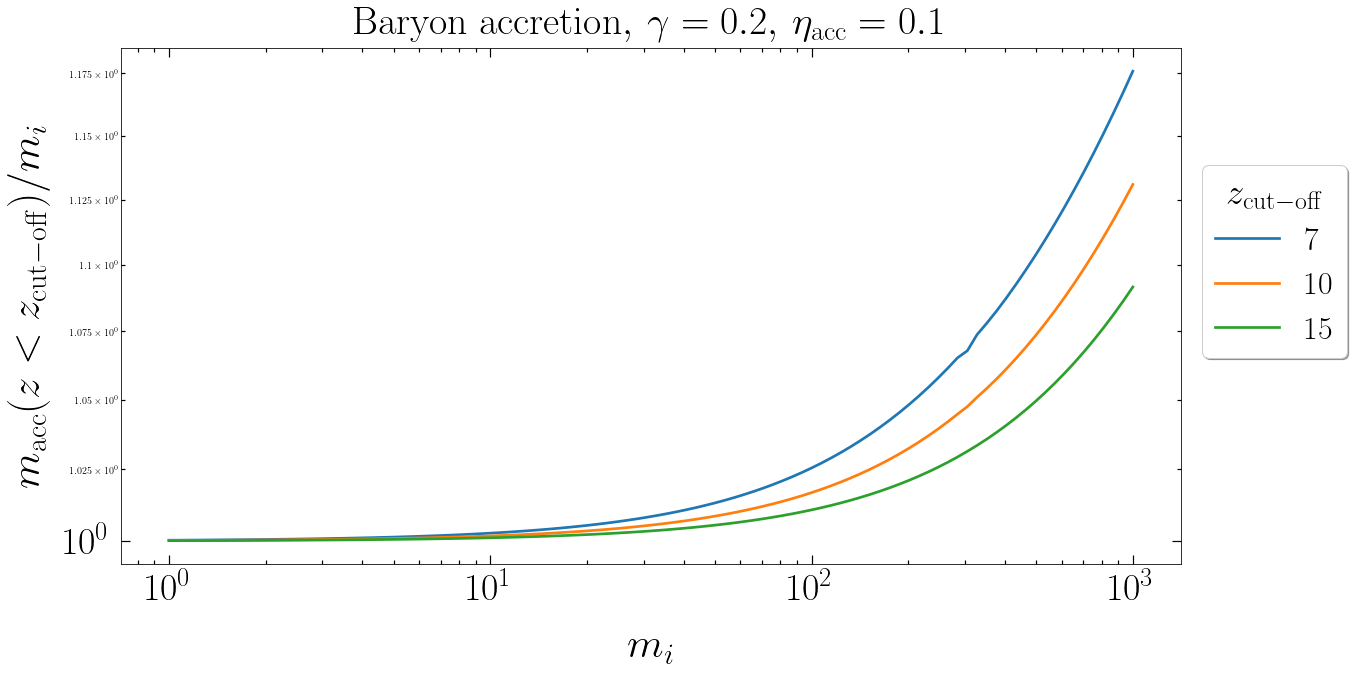

In [21]:
# Baryon accretion in radiation domination for different values of z_cut-off.
# m_f(z < z_cut-off)/m_i 



colors = ['C0', 'C1','C2','C3','C4', 'C5']
fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr = np.zeros(len(m1_arr))
colors = ['C0', 'C1', 'C2']
plot_lines = []


for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m1 in enumerate(m1_arr):
        γ = 0.2
        z_1i = 1e4   # as a trial value
        y_1i = m1
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, 100)
        sol1 = solve_ivp(m_Luca, t_span = [t1[0], t1[-1]], y0 = [y_1i],  t_eval = t1)
        t1 = sol1.t
        y1 = sol1.y[0]


        z_2i = z_eq
        y_2i = y1[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, 100)
        sol2 = solve_ivp(m_Luca, t_span = [t2[0], t2[-1]], y0 = [y_2i],  t_eval = t2)
        t2 = sol2.t
        y2 = sol2.y[0]



        z_3i = z_rec
        y_3i = y2[-1]
        z_cut_off3 = z_th
        t3 = np.geomspace(z_3i, z_cut_off3, 100)
        sol3 = solve_ivp(m_Luca, t_span = [t3[0], t3[-1]], y0 = [y_3i],  t_eval = t3)
        t3 = sol3.t
        y3 = sol3.y[0]

        
        z_4i = z_cut_off3
        y_4i = y3[-1]
        z_cut_off4 = 70
        t4 = np.geomspace(z_4i, z_cut_off4, 100)
        sol4 = solve_ivp(m_Luca, t_span = [t4[0], t4[-1]], y0 = [y_4i],  t_eval = t4)
        t4 = sol4.t
        y4 = sol4.y[0]


        z_5i = z_cut_off4
        y_5i = y4[-1]
        z_cut_off5 = 40
        t5 = np.geomspace(z_5i, z_cut_off5, 100)
        sol5 = solve_ivp(m_Luca, t_span = [t5[0], t5[-1]], y0 = [y_5i],  t_eval = t5)
        t5 = sol5.t
        y5 = sol5.y[0]


        z_6i = z_cut_off5
        y_6i = y5[-1]
        z_cut_off6 = z_cut
        t6 = np.geomspace(z_6i, z_cut, 100)
        sol6 = solve_ivp(m_Luca, t_span = [t6[0], t6[-1]], y0 = [y_6i],  t_eval = t6)
        t6 = sol6.t
        y6 = sol6.y[0]



        T = np.concatenate((t1, t2, t3, t4, t5, t6), axis = None)
        Y = np.concatenate((y1, y2, y3, y4, y5, y6), axis = None)

        mf_arr[j] = sol6.y[0][-2]
        
    ax.loglog(m1_arr, np.divide(mf_arr, m1_arr))
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.yaxis.get_offset_text().set_fontsize(38)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 43, labelpad = 20)
plt.ylabel(r'$m_\mathrm{acc}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 43, labelpad = 14)
plt.legend(['$7$', '$10$', '$15$'], 
           prop = {'size':32}, loc = (1.02, 0.4), shadow = True, 
           title = '$z_\mathrm{cut-off}$' ,
           title_fontsize = 37, facecolor = 'white', fontsize = 65)
#plt.xlim(1e16, 0.5*z_cut_off)
plt.xscale('log')
plt.title(r'Baryon accretion$,\, \gamma = 0.2, \,\eta_\mathrm{acc} = 0.1$', fontsize = 40, pad = 13)
#plt.savefig('bacc_z_diff_cutoff.pdf', bbox_inches = 'tight')
plt.show()

In [2]:
sol = odeint(m_Luca, y0 = m, t=t, t_first = True)


In [3]:
5.7**2

32.49

In [4]:
32.49e6

32490000.0

In [ ]:
(6.67e-11* 1.989e30)/(3.249e7 * 3.0857e16)

0.00013232966260141835